In [ ]:
# %pip install networkx

In [1]:
# Base imports
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# Classifier imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Graph of Thrones

Let's take a look at a dataset containing the characters that appear in G.R.R Martin's epic fantasy series *A Song of Ice and Fire*. Can we predict who lives and dies in the first book based on a character's Allegiance, Gender, Nobility and the chapter in which they are introduced? 

In [2]:
# Get a list of characters from the first book, print the first 5
characters =[]
with open('data/asoiaf-book1-nodes.csv') as f: [characters.append(line.split(',')[1].strip()) for line in f]
characters.pop(0) # pop out the label
characters[:5]

['Addam Marbrand',
 'Aegon I Targaryen',
 'Aemon Targaryen (Maester Aemon)',
 'Aerys II Targaryen',
 'Aggo']

In [3]:
# Read in data regarding deaths
death_df = pd.read_csv('data/character-deaths.csv')
death_df.head()

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0
1,Aegon Frey (Jinglebell),None,299.0,3.0,51.0,49.0,1,1,0,0,1,0,0
2,Aegon Targaryen,House Targaryen,NaN,NaN,NaN,5.0,1,1,0,0,0,0,1
3,Adrack Humble,House Greyjoy,300.0,5.0,20.0,20.0,1,1,0,0,0,0,1
4,Aemon Costayne,Lannister,NaN,NaN,NaN,NaN,1,1,0,0,1,0,0


In [5]:
# Create target variable
death_df['Dead'] = death_df['Death Year'].apply(lambda x: 1 if x==x else 0)

In [6]:
# Compare count of Characters in each set
print(f"""Total Characters: {len(death_df)}, First Book Characters: {len(death_df.query(f'Name in {characters}'))}""")

Total Characters: 917, First Book Characters: 156


In [8]:
# Grab death data from Characters in the first book
first_deaths = death_df.query(f'Name in {characters}').reset_index(drop=True)
first_deaths.head()

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,Dead
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0,0
1,Aggo,House Targaryen,NaN,NaN,NaN,54.0,1,0,1,1,1,0,1,0
2,Albett,Night's Watch,NaN,NaN,NaN,26.0,1,0,1,0,0,0,0,0
3,Alliser Thorne,Night's Watch,NaN,NaN,NaN,19.0,1,0,1,1,1,0,1,0
4,Alyn,House Stark,298.0,3.0,34.0,12.0,1,0,1,0,0,0,0,1


In [9]:
# Grab relevant features and one hot encode categorical data (Allegiances)
features = ['Name','Book Intro Chapter','Gender','Nobility','Dead']
df=pd.concat([first_deaths[features],pd.get_dummies(first_deaths['Allegiances'], prefix='allegiance',drop_first=True)],axis=1)
df.head()


,Name,Book Intro Chapter,Gender,Nobility,Dead,allegiance_Baratheon,allegiance_House Arryn,allegiance_House Baratheon,allegiance_House Greyjoy,allegiance_House Lannister,...,allegiance_House Tully,allegiance_House Tyrell,allegiance_Lannister,allegiance_Night's Watch,allegiance_None,allegiance_Stark,allegiance_Targaryen,allegiance_Tully,allegiance_Tyrell,allegiance_Wildling
0,Addam Marbrand,56.0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Aggo,54.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Albett,26.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,Alliser Thorne,19.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Alyn,12.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


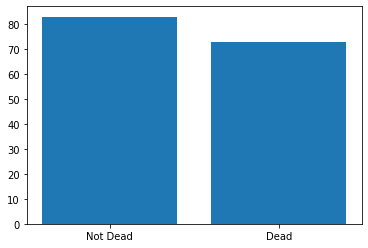

In [10]:
# Explore the balance of our target class
plt.bar(['Not Dead','Dead'],df.Dead.value_counts());

## Predicting Death

### Tabular Data
>*Valar Morghulis* (All Men must die) -- A Clash of Kings

In [11]:
# Try a collection of classifiers
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Random Forest", "Neural Net","Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=3,random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    LogisticRegression(solver='liblinear', random_state=42)]

In [12]:
# Prepare data
X, y = df.drop(['Name','Dead'],axis=1), df['Dead']
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Untuned classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(f'Base F1 Score for {name}: {f1_score(y_test, clf.predict(X_test)):.2f}')

Base F1 Score for Nearest Neighbors: 0.48
Base F1 Score for Linear SVM: 0.47
Base F1 Score for RBF SVM: 0.38
Base F1 Score for Random Forest: 0.33
Base F1 Score for Neural Net: 0.47
Base F1 Score for Logistic Regression: 0.37


We now have some baseline scores for models built solely on tabular data.

### Graph Data
>Every Man must die, but first He must live. -- Storm of Swords

Let's see if we can capture more information about these characters based on their interactions with each other.

In [15]:
# Import graph database
book1_df = pd.read_csv('data/asoiaf-book1-edges.csv')
G1 = nx.Graph()
for row in book1_df.iterrows():
    G1.add_edge(row[1]['Source'].replace('-',' '), row[1]['Target'].replace('-',' '), weight=row[1]['weight'])

#### EDA
What information do the edge weights capture?

In [17]:
# Inspect relationship/edge
G1.get_edge_data('Tyrion Lannister','Jon Snow')

{'weight': 56}

We have created a network with characters as **Nodes** connected by **Weighted Edges** where the weight corresponds to the amount of dialogue exchanged with each other in the first book. Is this directed or undirected?

/Users/jacksongilkey/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


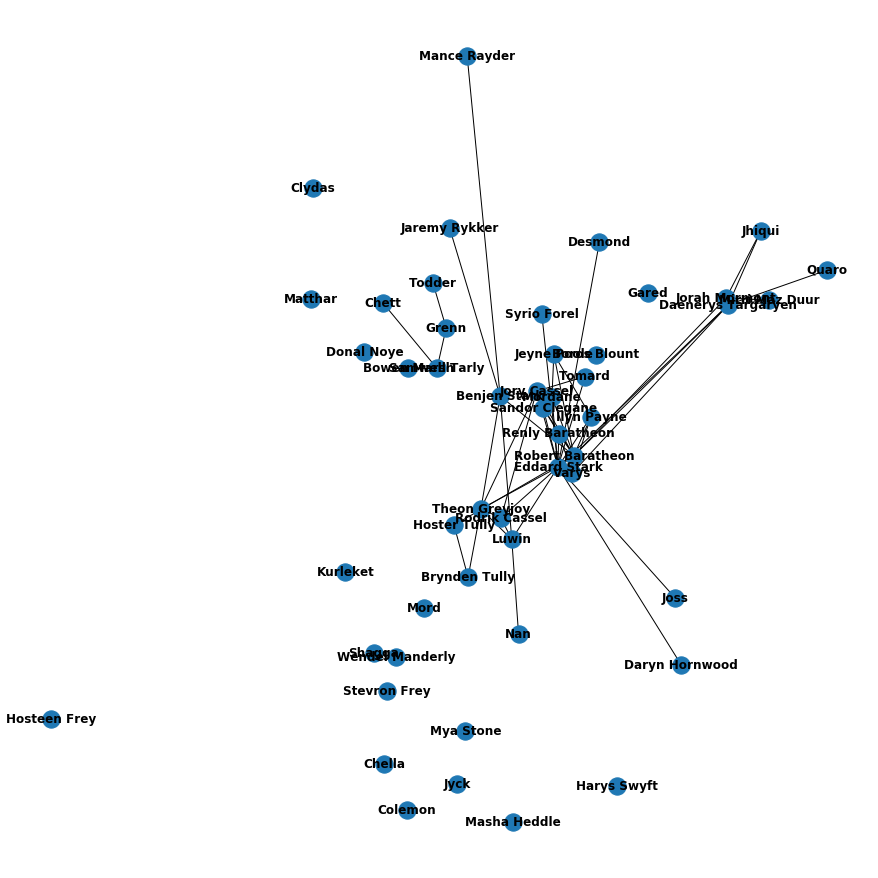

In [18]:
# Visualize a sample of the graph
plt.figure(figsize=(12,12))
nx.draw(G1.subgraph(df.sample(n=50, random_state=42).Name), with_labels=True, font_weight='bold', pos=nx.spring_layout(G1))
plt.draw()

What does the distribution of weights on the edges look like?

In [19]:
wts=[]
relationships=[]
# Loop through each node and its adjacent nodes and capture its weight 
for n, nbrs in G1.adj.items():
    for nbr, eattr in nbrs.items():
        wt = eattr['weight']
        wts.append(wt)
        relationships.append((wt,n,nbr))

In [20]:
# Examine weighted relationship, skip every other one (undirected relationship)
print(sorted(relationships,key=(lambda x: x[0]),reverse=True)[:10:2])

[(291, 'Eddard Stark', 'Robert Baratheon'), (112, 'Bran Stark', 'Robb Stark'), (104, 'Arya Stark', 'Sansa Stark'), (101, 'Daenerys Targaryen', 'Drogo'), (87, 'Joffrey Baratheon', 'Sansa Stark')]


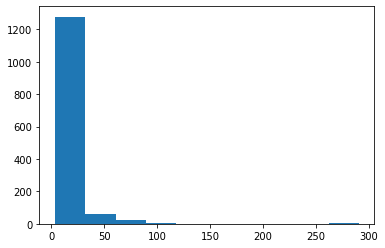

In [21]:
# Plot distribution of weights
plt.hist(wts);

### Graph Algorithms

Using Graph Theory, let us create some metrics from our network to augment the tabular data used in the models earlier.

#### Degree (number of connections normalized by number of possible connections)


In [22]:
# Calculate degree and assign it to each node
for name, degree in nx.degree_centrality(G1).items():
    G1.nodes[name]['degree']=degree

In [23]:
G1.nodes['Tyrion Lannister']

{'degree': 0.24731182795698928}

In [24]:
G1.nodes['Hosteen Frey']

{'degree': 0.010752688172043012}

#### Label propagation (community detection algorithm akin to KNN)

In [25]:
# Assign community label to each node in the community and print out the communities
communities=[]
for label, community in enumerate(nx.algorithms.community.label_propagation.label_propagation_communities(G1)):
    communities.append(community)
    print(f'Community {label}: {community}')
    for name in community:
        G1.nodes[name]['community'] = label

Community 0: {'Waymar Royce', 'Gared', 'Will (prologue)'}
Community 1: {'Jared Frey', 'Hosteen Frey', 'Danwell Frey'}
Community 2: {'Cohollo', 'Rakharo', 'Illyrio Mopatis', 'Jhiqui', 'Doreah', 'Mirri Maz Duur', 'Viserys Targaryen', 'Qotho', 'Rhaego', 'Jorah Mormont', 'Jhogo', 'Eroeh', 'Jommo', 'Haggo', 'Irri', 'Quaro', 'Drogo', 'Ogo', 'Aggo', 'Daenerys Targaryen', 'Fogo'}
Community 3: {'Morrec', 'Jyck'}
Community 4: {'Paxter Redwyne', 'Mace Tyrell'}
Community 5: {'Jon Snow', 'Grenn', 'Bowen Marsh', 'Aemon Targaryen (Maester Aemon)', 'Pypar', 'Samwell Tarly', 'Dareon', 'Jafer Flowers', 'Todder', 'Hobb', 'Albett', 'Alliser Thorne', 'Rast', 'Jaremy Rykker', 'Matthar', 'Jeor Mormont', 'Randyll Tarly', 'Clydas', 'Dywen', 'Chett', 'Donal Noye', 'Halder', 'Othor'}
Community 6: {'Coratt', 'Conn'}
Community 7: {'Dolf', 'Ulf son of Umar', 'Shagga', 'Timett'}
Community 8: {'Cayn', 'Kurleket', 'Jacks', 'Jeyne Poole', 'Harwin', 'Tobho Mott', 'Cersei Lannister', 'Desmond', 'Karyl Vance', 'Addam Marb

What do these communities tell us about the underlying data?

#### Centrality

In [26]:
# Assign betweenness metric
for name, betweenness in nx.betweenness_centrality(G1, weight='weight', seed=42).items():
    G1.nodes[name]['betweenness']=betweenness

In [27]:
G1.nodes['Tyrion Lannister']

{'degree': 0.24731182795698928,
 'community': 8,
 'betweenness': 0.15311225972516293}

In [28]:
G1.nodes['Hosteen Frey']

{'degree': 0.010752688172043012, 'community': 1, 'betweenness': 0.0}

What does the betweenness tell us about these two characters?

In [29]:
# Assign pagerank
for name, rank in nx.pagerank(G1, weight='weight').items():
    G1.nodes[name]['rank']=rank

In [30]:
G1.nodes['Tyrion Lannister']

{'degree': 0.24731182795698928,
 'community': 8,
 'betweenness': 0.15311225972516293,
 'rank': 0.04367631315626212}

In [31]:
G1.nodes['Hosteen Frey']

{'degree': 0.010752688172043012,
 'community': 1,
 'betweenness': 0.0,
 'rank': 0.0033238798195197603}

What does the pagerank tell us about these two characters?

## Augmented Data

In [32]:
# Helper function to augment table data
def graph_of_thrones(name):
    if G1.nodes[name]:
        return [G1.nodes[name]['betweenness'], G1.nodes[name]['community'], G1.nodes[name]['rank'], G1.nodes[name]['degree']]
    return [None, None, None, None]

In [33]:
# Add metrics to original DataFrame
graph_df = pd.concat([df,pd.DataFrame(df.apply(lambda x: graph_of_thrones(x.Name),axis=1).values.tolist(),columns=['Betweenness','Community','Rank','Degree'])],axis=1)
graph_df.columns

Index(['Name', 'Book Intro Chapter', 'Gender', 'Nobility', 'Dead',
       'allegiance_Baratheon', 'allegiance_House Arryn',
       'allegiance_House Baratheon', 'allegiance_House Greyjoy',
       'allegiance_House Lannister', 'allegiance_House Stark',
       'allegiance_House Targaryen', 'allegiance_House Tully',
       'allegiance_House Tyrell', 'allegiance_Lannister',
       'allegiance_Night's Watch', 'allegiance_None', 'allegiance_Stark',
       'allegiance_Targaryen', 'allegiance_Tully', 'allegiance_Tyrell',
       'allegiance_Wildling', 'Betweenness', 'Community', 'Rank', 'Degree'],
      dtype='object')

In [34]:
# Create dummy variables for categorical feature
augmented_df=pd.concat([graph_df.drop('Community',axis=1),pd.get_dummies(graph_df['Community'], prefix='community',drop_first=True)],axis=1)

In [35]:
# Inspect remaining columns
augmented_df.describe()

,Book Intro Chapter,Gender,Nobility,Dead,allegiance_Baratheon,allegiance_House Arryn,allegiance_House Baratheon,allegiance_House Greyjoy,allegiance_House Lannister,allegiance_House Stark,...,Rank,Degree,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,...,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,28.519231,0.878205,0.519231,0.467949,0.006410,0.025641,0.012821,0.006410,0.051282,0.128205,...,0.005697,0.041839,0.019231,0.121795,0.012821,0.012821,0.128205,0.006410,0.019231,0.666667
std,19.931972,0.328102,0.501239,0.500579,0.080064,0.158571,0.112862,0.080064,0.221283,0.335395,...,0.009641,0.054717,0.137777,0.328102,0.112862,0.112862,0.335395,0.080064,0.137777,0.472923
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000932,0.005376,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001353,0.010753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002526,0.024194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,43.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005204,0.044355,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,71.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.072362,0.354839,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
# Prepare data 
X, y = augmented_df.drop(['Name','Dead'],axis=1), augmented_df['Dead']
# X = StandardScaler().fit_transform(X)
GX_train, GX_test, Gy_train, Gy_test = \
        train_test_split(X, y, test_size=.2, random_state=42)
g_scaler = StandardScaler()
GX_train = g_scaler.fit_transform(GX_train)
GX_test = g_scaler.transform(GX_test)

In [37]:
# Untuned Classifiers with number of interactions as weight
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(f'Base F1 Score for {name}: {f1_score(y_test, clf.predict(X_test))}')
    clf.fit(GX_train, Gy_train)
    print(f'Graph Augmented F1 Score for {name}: {f1_score(Gy_test, clf.predict(GX_test))} \n')

Base F1 Score for Nearest Neighbors: 0.48484848484848486
Graph Augmented F1 Score for Nearest Neighbors: 0.39999999999999997 

Base F1 Score for Linear SVM: 0.4666666666666667
Graph Augmented F1 Score for Linear SVM: 0.4827586206896552 

Base F1 Score for RBF SVM: 0.38461538461538464
Graph Augmented F1 Score for RBF SVM: 0.24000000000000005 

Base F1 Score for Random Forest: 0.3333333333333333
Graph Augmented F1 Score for Random Forest: 0.2962962962962963 

Base F1 Score for Neural Net: 0.4666666666666667
Graph Augmented F1 Score for Neural Net: 0.4666666666666667 

Base F1 Score for Logistic Regression: 0.3703703703703703
Graph Augmented F1 Score for Logistic Regression: 0.5 



### Reflection
We can see an improvement in some of the models but a drop in others. Consider how we set up our network with weighted connections; each edge had the number of interactions between the two characters. How do the models think of the weights for their algorithms?

In [38]:
# The above process has been automated into a pipeline to compare results
from helpers import pipeline

[(291, 'Eddard Stark', 'Robert Baratheon'), (112, 'Bran Stark', 'Robb Stark'), (104, 'Arya Stark', 'Sansa Stark'), (101, 'Daenerys Targaryen', 'Drogo'), (87, 'Joffrey Baratheon', 'Sansa Stark')]


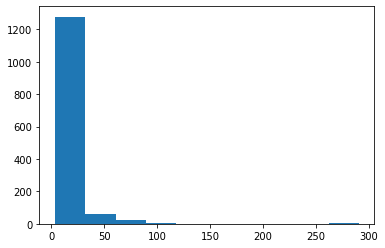

Base F1 Score for Nearest Neighbors: 0.48484848484848486
Graph Augmented F1 Score for Nearest Neighbors: 0.39999999999999997 

Base F1 Score for Linear SVM: 0.4666666666666667
Graph Augmented F1 Score for Linear SVM: 0.4827586206896552 

Base F1 Score for RBF SVM: 0.38461538461538464
Graph Augmented F1 Score for RBF SVM: 0.24000000000000005 

Base F1 Score for Random Forest: 0.3333333333333333
Graph Augmented F1 Score for Random Forest: 0.2962962962962963 

Base F1 Score for Neural Net: 0.4666666666666667
Graph Augmented F1 Score for Neural Net: 0.4666666666666667 

Base F1 Score for Logistic Regression: 0.3703703703703703
Graph Augmented F1 Score for Logistic Regression: 0.5 



In [39]:
# Untuned Classifiers with number of interactions as weights
pipeline(df, names, classifiers, 'weight')

In [40]:
# Untuned Classifiers with no weights
pipeline(df, names, classifiers)

Base F1 Score for Nearest Neighbors: 0.48484848484848486
Graph Augmented F1 Score for Nearest Neighbors: 0.45161290322580644 

Base F1 Score for Linear SVM: 0.4666666666666667
Graph Augmented F1 Score for Linear SVM: 0.4666666666666667 

Base F1 Score for RBF SVM: 0.38461538461538464
Graph Augmented F1 Score for RBF SVM: 0.3076923076923077 

Base F1 Score for Random Forest: 0.3333333333333333
Graph Augmented F1 Score for Random Forest: 0.3333333333333333 

Base F1 Score for Neural Net: 0.4666666666666667
Graph Augmented F1 Score for Neural Net: 0.5161290322580646 

Base F1 Score for Logistic Regression: 0.3703703703703703
Graph Augmented F1 Score for Logistic Regression: 0.5185185185185185 



[(0.3333333333333333, 'Addam Marbrand', 'Jaime Lannister'), (0.3333333333333333, 'Jaime Lannister', 'Galbart Glover'), (0.3333333333333333, 'Jaime Lannister', 'Harys Swyft'), (0.3333333333333333, 'Jaime Lannister', 'Rickard Karstark'), (0.3333333333333333, 'Jaime Lannister', 'Sansa Stark')]


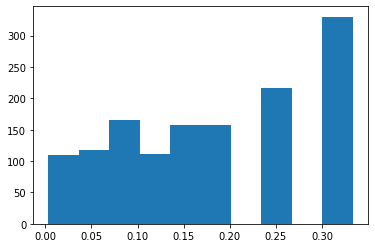

Base F1 Score for Nearest Neighbors: 0.48484848484848486
Graph Augmented F1 Score for Nearest Neighbors: 0.45161290322580644 

Base F1 Score for Linear SVM: 0.4666666666666667
Graph Augmented F1 Score for Linear SVM: 0.4666666666666667 

Base F1 Score for RBF SVM: 0.38461538461538464
Graph Augmented F1 Score for RBF SVM: 0.42857142857142855 

Base F1 Score for Random Forest: 0.3333333333333333
Graph Augmented F1 Score for Random Forest: 0.5 

Base F1 Score for Neural Net: 0.4666666666666667
Graph Augmented F1 Score for Neural Net: 0.4666666666666667 

Base F1 Score for Logistic Regression: 0.3703703703703703
Graph Augmented F1 Score for Logistic Regression: 0.5185185185185185 



In [41]:
# Untuned Classifiers with reciprocal number of interactions as weight
pipeline(df, names, classifiers, weight='inverse')

## Conclusion
Graph networks and algorithms are a powerful tool to explore the relationships between objects in our data. Networks can be used not only to visualize data but also to create new features that can be useful for machine learning. It is not the solution to every problem, and there is no guarantee that every class of model will be improved by including this type of data. Like any other type of data it is important to explore your features and examine your assumptions.
> It is one thing to be **clever** and another to be **wise**. -- A Game of Thrones